In [8]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image

from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

In [9]:
#Default dimensions we found online
img_width, img_height = 224, 224 
 
#Create a bottleneck file
top_model_weights_path = 'model.h5'
# loading up our datasets
train_data_dir = 'FLIR/train'
test_data_dir = 'FLIR/test'
 
# number of epochs to train top model 
epochs = 7 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 50 

In [10]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255) 

In [11]:
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train) 
 
np.save('train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time:', elapsed)

Found 811 images belonging to 3 classes.


C:\Users\DELL\AppData\Local\Temp\ipykernel_15052\2126989882.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)


Time: 0:00:56.000290


In [12]:
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    test_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_test_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_test = int(math.ceil(nb_test_samples / batch_size)) 
 
bottleneck_features_test = vgg16.predict_generator(generator, predict_size_test) 
 
np.save('test.npy', bottleneck_features_test)
end= datetime.datetime.now()
elapsed= end-start
print ('Time:', elapsed)

Found 227 images belonging to 3 classes.


C:\Users\DELL\AppData\Local\Temp\ipykernel_15052\2259607133.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_test = vgg16.predict_generator(generator, predict_size_test)


Time: 0:00:17.063635


In [13]:
generator_top = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load('train.npy') 
 
# get the class labels for the training data, in the original order 
train_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 811 images belonging to 3 classes.


In [15]:
generator_top = datagen.flow_from_directory(
    test_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_test_samples = len(generator_top.filenames) 
num_classes2 = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
test_data = np.load('test.npy') 
 
# get the class labels for the training data, in the original order 
test_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
test_labels = to_categorical(test_labels, num_classes=num_classes2)

Found 227 images belonging to 3 classes.


In [17]:
start = datetime.datetime.now()

model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.5)) 
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

history = model.fit(train_data, train_labels,epochs=20,batch_size=batch_size,validation_data=(test_data, test_labels))
model.save_weights(top_model_weights_path)
(eval_loss, eval_accuracy) = model.evaluate(test_data, test_labels, batch_size=batch_size,verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time:' , elapsed)

Epoch 1/20
17/17 [==============================] - 1s 45ms/step - loss: 0.9252 - acc: 0.6030 - val_loss: 0.5509 - val_acc: 0.7533
Epoch 2/20
17/17 [==============================] - 1s 31ms/step - loss: 0.3853 - acc: 0.8520 - val_loss: 0.2897 - val_acc: 0.9163
Epoch 3/20
17/17 [==============================] - 0s 23ms/step - loss: 0.2311 - acc: 0.9309 - val_loss: 0.2006 - val_acc: 0.9383
Epoch 4/20
17/17 [==============================] - 0s 27ms/step - loss: 0.1541 - acc: 0.9667 - val_loss: 0.1701 - val_acc: 0.9471
Epoch 5/20
17/17 [==============================] - 0s 20ms/step - loss: 0.1126 - acc: 0.9704 - val_loss: 0.1025 - val_acc: 0.9780
Epoch 6/20
17/17 [==============================] - 0s 27ms/step - loss: 0.0978 - acc: 0.9741 - val_loss: 0.0893 - val_acc: 0.9780
Epoch 7/20
17/17 [==============================] - 0s 20ms/step - loss: 0.0713 - acc: 0.9852 - val_loss: 0.0757 - val_acc: 0.9824
Epoch 8/20
17/17 [==============================] - 0s 21ms/step - loss: 0.0518 - a

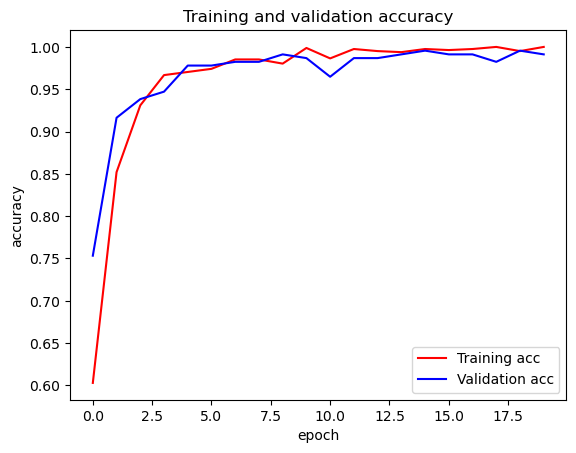

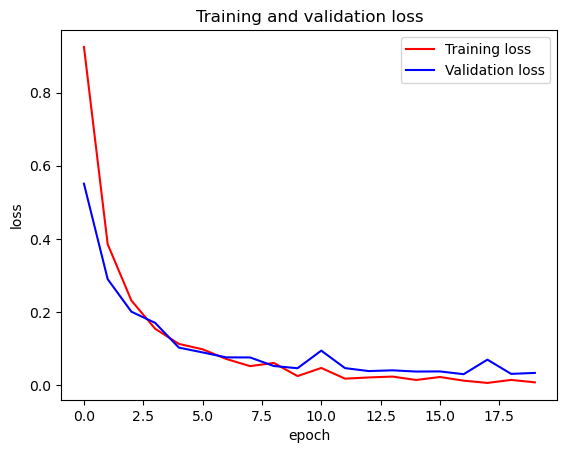

In [18]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [19]:
model.evaluate(test_data,test_labels)

8/8 [==============================] - 0s 8ms/step - loss: 0.0332 - acc: 0.9912


[0.033226024359464645, 0.9911894202232361]

In [20]:
preds=np.round(model.predict(test_data),0)
print('rounded test_labes',preds)

8/8 [==============================] - 0s 18ms/step
rounded test_labes [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 

In [21]:
emotion=['car','cat','man']
classification_metrics=metrics.classification_report(test_labels,preds,target_names=emotion)
print(classification_metrics)

              precision    recall  f1-score   support

         car       1.00      0.99      0.99        93
         cat       0.99      0.99      0.99        70
         man       0.98      1.00      0.99        64

   micro avg       0.99      0.99      0.99       227
   macro avg       0.99      0.99      0.99       227
weighted avg       0.99      0.99      0.99       227
 samples avg       0.99      0.99      0.99       227



In [22]:
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
 
#Add Normalization Option
 #prints pretty confusion metric with normalization option ‘’’
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
# print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

Normalized confusion matrix


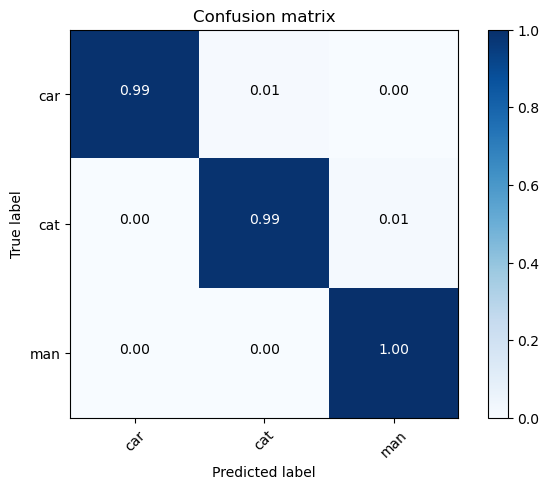

In [23]:
plot_confusion_matrix(confusion_matrix,['car','cat','man'],normalize=True)

[INFO] loading and preprocessing image…
1/1 [==============================] - 0s 21ms/step
ID: 0, Label: car 100.0%
ID: 1, Label: cat 0.0%
ID: 2, Label: man 0.0%
Final Decision:
.
..
...
1/1 [==============================] - 0s 17ms/step
ID:[9.9999225e-01 7.6353872e-06 7.4130227e-08],Label:car


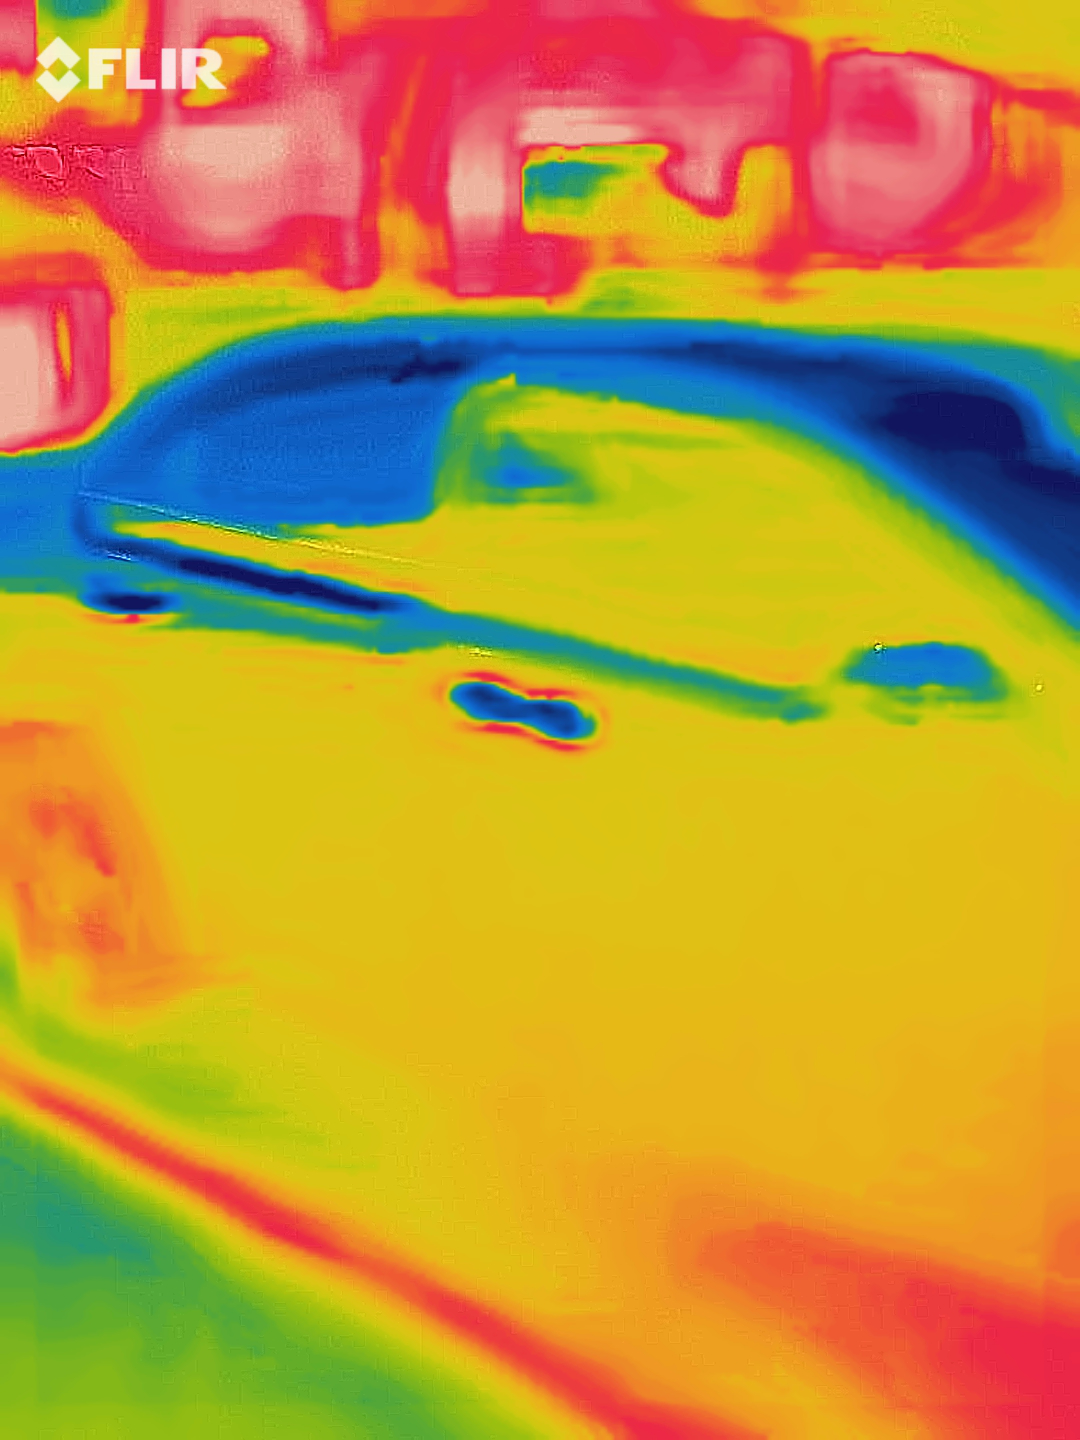

In [30]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image…") 
    image = load_img(file_path, target_size=(224, 224)) 
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image /= 255. 
    return image

def test_single_image(path):
    animals = ['car', 'cat','man']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images) 
    preds = model.predict(bt_prediction)
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
        
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
    time.sleep(.2)
    class_predicted = model.predict(bt_prediction)
    predict_classes=np.argmax(class_predicted,axis=1)
    class_dictionary = generator_top.class_indices 
    inv_map = {v: k for k, v in class_dictionary.items()} 
    print("ID:{},Label:{}".format(class_predicted[0],  inv_map[predict_classes[0]])) 
    
    return load_img(path)
path = 'C:/Users/DELL/Desktop/Thermal/FLIR/Test/car/flir_20200116T174957.jpg'
test_single_image(path)

Actual Image:C:/Users/DELL/Desktop/Thermal/FLIR/Test/man/flir_20200104T125347 (2).jpg
1/1 [==============================] - 0s 23ms/step
ID: 0, Label: car 0.0%
ID: 1, Label: cat 0.0%
ID: 2, Label: man 100.0%
Final Decision:
.
..
...
1/1 [==============================] - 0s 14ms/step
Top Score ID Number is:[5.6677674e-10 1.5411650e-12 1.0000000e+00],Predicted Label is:man
Actual Image:C:/Users/DELL/Desktop/Thermal/FLIR/Test/man/flir_20200104T125415.jpg
1/1 [==============================] - 0s 20ms/step
ID: 0, Label: car 0.0%
ID: 1, Label: cat 0.0%
ID: 2, Label: man 100.0%
Final Decision:
.
..
...
1/1 [==============================] - 0s 21ms/step
Top Score ID Number is:[2.4989447e-08 2.7642150e-10 1.0000000e+00],Predicted Label is:man
Actual Image:C:/Users/DELL/Desktop/Thermal/FLIR/Test/man/flir_20200104T125439 (2).jpg
1/1 [==============================] - 0s 23ms/step
ID: 0, Label: car 0.0%
ID: 1, Label: cat 0.0%
ID: 2, Label: man 100.0%
Final Decision:
.
..
...
1/1 [=============

ValueError: num must be an integer with 1 <= num <= 30, not 31

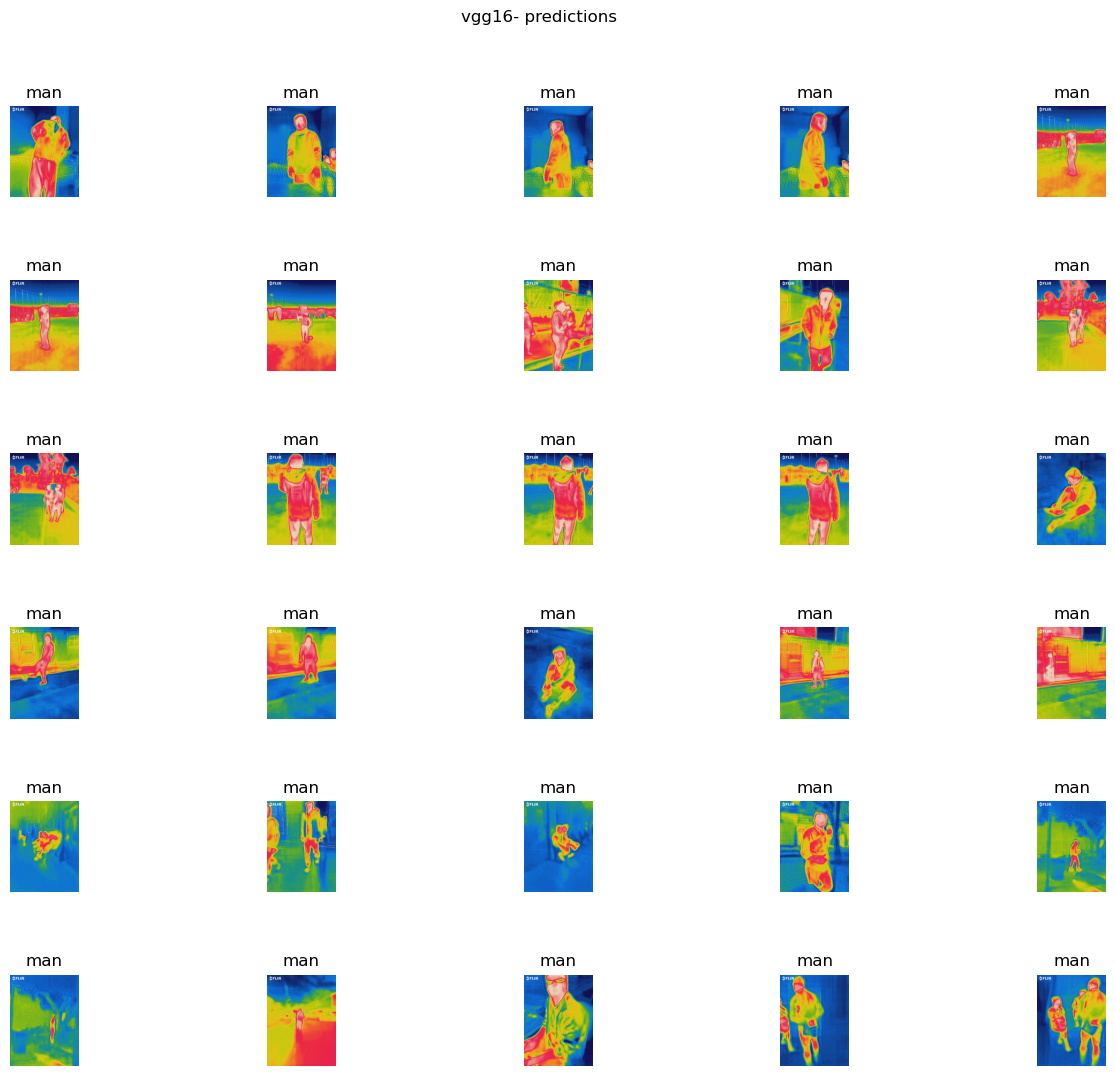

In [40]:
def read_image(file_path):
    print("Actual Image:"+file_path) 
    image = load_img(file_path, target_size=(224, 224)) 
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image /= 255. 
    return image


import os
import matplotlib.pyplot as plt
import matplotlib.image as mping
train_dir=os.path.join('C:/Users/DELL/Desktop/Thermal/FLIR/Test/man/')
train = os.listdir(train_dir)
fname1 = [os.path.join(train_dir,fname)
        for fname in train[:]]


plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=0.9)
plt.subplots_adjust(wspace=0.9)
plt.subplots_adjust(bottom=0.1)
plt.subplots_adjust(top=0.9)
plt.subplots_adjust(right=0.9)
plt.subplots_adjust(left=0.125)
for i,fname in enumerate(fname1):
    img = mping.imread(fname)
    sp = plt.subplot(6,5,i+1)
    sp.axis('off')
    animals = ['car', 'cat','man']
    images = read_image(fname)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images) 
    
    preds = model.predict(bt_prediction)
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
        
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
    time.sleep(.2)
    class_predicted = model.predict(bt_prediction)
    predict_classes=np.argmax(class_predicted,axis=1)
    class_dictionary = generator_top.class_indices 
    inv_map = {v: k for k, v in class_dictionary.items()} 
    print("Top Score ID Number is:{},Predicted Label is:{}".format(class_predicted[0],inv_map[predict_classes[0]])) 

    plt.title(inv_map[predict_classes[0]])
    plt.imshow(img)
    plt.suptitle("vgg16- predictions")
plt.show()

Actual Image:C:/Users/DELL/Desktop/Thermal/FLIR/Test/mixed/flir_20200116T174951 (2).jpg
1/1 [==============================] - 0s 21ms/step
ID: 0, Label: car 99.99%
ID: 1, Label: cat 0.0%
ID: 2, Label: man 0.01%
Final Decision:
.
..
...
1/1 [==============================] - 0s 20ms/step
Top Score ID Number is:[9.9992836e-01 1.2182188e-05 5.9449008e-05],Predicted Label is:car
Actual Image:C:/Users/DELL/Desktop/Thermal/FLIR/Test/mixed/flir_20200116T174956.jpg
1/1 [==============================] - 0s 21ms/step
ID: 0, Label: car 100.0%
ID: 1, Label: cat 0.0%
ID: 2, Label: man 0.0%
Final Decision:
.
..
...
1/1 [==============================] - 0s 21ms/step
Top Score ID Number is:[9.999993e-01 7.212587e-07 1.802594e-08],Predicted Label is:car
Actual Image:C:/Users/DELL/Desktop/Thermal/FLIR/Test/mixed/flir_20200116T175025.jpg
1/1 [==============================] - 0s 21ms/step
ID: 0, Label: car 100.0%
ID: 1, Label: cat 0.0%
ID: 2, Label: man 0.0%
Final Decision:
.
..
...
1/1 [=============

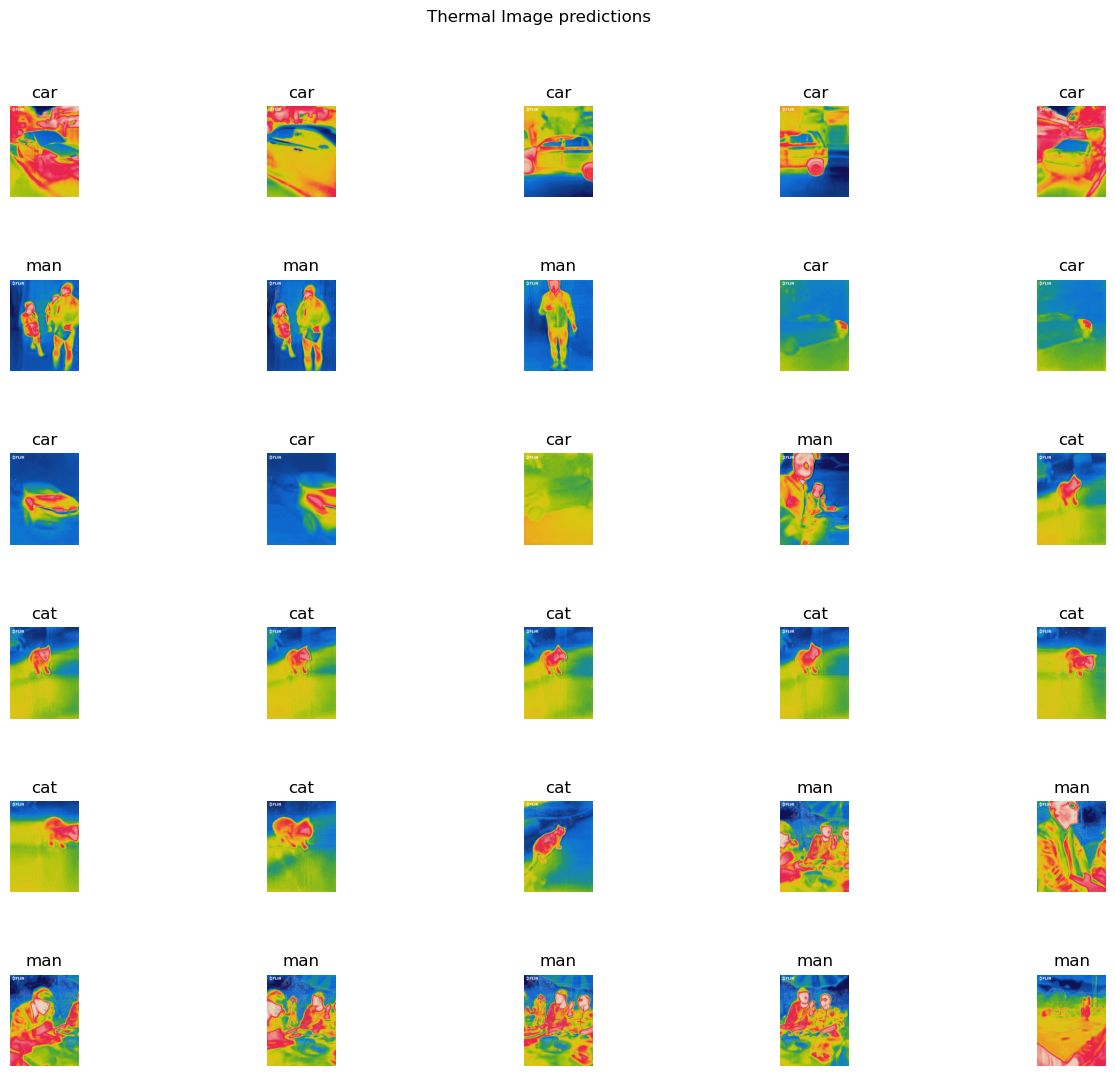

In [44]:
def read_image(file_path):
    print("Actual Image:"+file_path) 
    image = load_img(file_path, target_size=(224, 224)) 
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image /= 255. 
    return image


import os
import matplotlib.pyplot as plt
import matplotlib.image as mping
train_dir=os.path.join('C:/Users/DELL/Desktop/Thermal/FLIR/Test/mixed/')
train = os.listdir(train_dir)
fname1 = [os.path.join(train_dir,fname)
        for fname in train[:]]


plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=0.9)
plt.subplots_adjust(wspace=0.9)
plt.subplots_adjust(bottom=0.1)
plt.subplots_adjust(top=0.9)
plt.subplots_adjust(right=0.9)
plt.subplots_adjust(left=0.125)
for i,fname in enumerate(fname1):
    img = mping.imread(fname)
    sp = plt.subplot(6,5,i+1)
    sp.axis('off')
    animals = ['car', 'cat','man']
    images = read_image(fname)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images) 
    
    preds = model.predict(bt_prediction)
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
        
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
    time.sleep(.2)
    class_predicted = model.predict(bt_prediction)
    predict_classes=np.argmax(class_predicted,axis=1)
    class_dictionary = generator_top.class_indices 
    inv_map = {v: k for k, v in class_dictionary.items()} 
    print("Top Score ID Number is:{},Predicted Label is:{}".format(class_predicted[0],inv_map[predict_classes[0]])) 

    plt.title(inv_map[predict_classes[0]])
    plt.imshow(img)
    plt.suptitle("Thermal Image predictions")
plt.show()